# Classic Machine Learning Methods

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters


In [5]:
df_train = pd.read_csv("data/ptbdb_train.csv", header=None) 
df_test = pd.read_csv("data/ptbdb_test.csv", header=None)

x_train = df_train[df_train.columns[0:187]].values
y_train = df_train[df_train.columns[187]].values
x_test = df_test[df_test.columns[0:187]].values
y_test = df_test[df_test.columns[187]].values

## Train ml models on raw data

### Regularized logistic regression

In [9]:
# logisitic regression, find the best hyperparameters

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(x_test)
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred)))



Best parameters: {'C': 0.1}
Test set F1 score: 0.88


### Train a bosted model

In [11]:


param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7, 9]}
clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(x_test)
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred)))


[LightGBM] [Info] Number of positive: 6723, number of negative: 2589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41867
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721972 -> initscore=0.954263
[LightGBM] [Info] Start training from score 0.954263
[LightGBM] [Info] Number of positive: 6723, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41875
[LightGBM] [Info] Number of data points in the train set: 9313, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721894 -> initscore=0.953877
[LightG

## Build pipeline with new engineered feature


In [5]:
# long format with id and time columns
df_train_long = pd.DataFrame(df_train[df_train.columns[0:187]])
df_train_long['id'] = df_train_long.index
df_train_long = df_train_long.melt(id_vars='id', var_name='time')
df_train_long['time'] = df_train_long['time'].astype(int)

df_test_long = pd.DataFrame(df_test[df_test.columns[0:187]])
df_test_long['id'] = df_test_long.index
df_test_long = df_test_long.melt(id_vars='id', var_name='time')
df_test_long['time'] = df_test_long['time'].astype(int)



In [6]:
# define new dataset with new features made with tsfresh
X_train = extract_features(df_train_long, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())


Feature Extraction: 100%|██████████| 20/20 [06:51<00:00, 20.57s/it]


In [7]:
# extract features for test set
X_test = extract_features(df_test_long, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())

Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


In [8]:
X_train_wo_nan = X_train.dropna(axis=1)
X_test_wo_nan = X_test.dropna(axis=1)

In [9]:
X_train_wo_nan.head()

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       1.0                   1.0          31.761560   
1                       1.0                   1.0          21.162685   
2                       1.0                   1.0          18.361812   
3                       1.0                   1.0          17.381913   
4                       1.0                   1.0          54.557505   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
0           8.927965                0.014062           -0.005376   
1           7.935466                0.032056           -0.005376   
2           5.907348                0.022110           -0.005247   
3           5.044730                0.023695           -0.005121   
4          22.240158                0.026340           -0.005345   

   value__mean_second_derivative_central  value__median  ...  \
0                               0.000728       0.178528  ...   
1                               0.002291       0.000000  ...   
2                               0.000764       0.071674  ...   
3                               0.000986       0.069616  ...   
4                               0.001266       0.352827  ...   

   value__fourier_entropy__bins_3  value__fourier_entropy__bins_5  \
0                        0.141337                        0.161651   
1                        0.117714                        0.117714   
2                        0.551940                        0.853715   
3                        0.161651                        0.381096   
4                        0.117714                        0.258354   

   value__fourier_entropy__bins_10  value__fourier_entropy__bins_100  \
0                         0.316683                          0.974941   
1                         0.176399                          1.274168   
2                         1.276388                          2.616993   
3                         0.862994                          2.195313   
4                         0.483485                          1.715575   

   value__permutation_entropy__dimension_3__tau_1  \
0                                        1.566183   
1                                        1.105742   
2                                        1.230186   
3                                        1.524769   
4                                        1.569708   

   value__permutation_entropy__dimension_4__tau_1  \
0                                        2.558113   
1                                        1.719584   
2                                        1.766055   
3                                        2.514057   
4                                        2.535120   

   value__permutation_entropy__dimension_5__tau_1  \
0                                        3.418415   
1                                        2.258974   
2                                        2.281631   
3                                        3.325593   
4                                        3.408794   

   value__permutation_entropy__dimension_6__tau_1  \
0                                        3.910249   
1                                        2.581583   
2                                        2.684533   
3                                        3.828358   
4                                        3.905917   

   value__permutation_entropy__dimension_7__tau_1  \
0                                        4.101044   
1                                        2.731673   
2                 

In [10]:
# save the new datasets with extracted features
X_train_wo_nan.to_csv("data/X_train_new_features.csv")
X_test_wo_nan.to_csv("data/X_test_new_features.csv")

In [3]:
X_train_wo_nan = pd.read_csv("data/X_train_new_features.csv")
X_test_wo_nan = pd.read_csv("data/X_test_new_features.csv")

In [11]:
# train logistic regression on new features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_wo_nan)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression(max_iter=10000)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
X_test = scaler.transform(X_test_wo_nan)
y_pred = grid_search.predict(X_test)
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred)))



Best parameters: {'C': 10}
Test set F1 score: 0.97


Number of selected features: 705


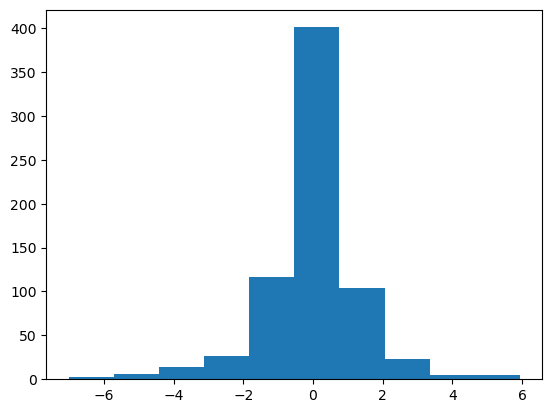

In [14]:
# show selected features
selected_features = X_train_wo_nan.columns[grid_search.best_estimator_.coef_[0] != 0]
# number of selected features
print("Number of selected features: {}".format(len(selected_features)))
# plot distribution of coefficients of selected features
import matplotlib.pyplot as plt
plt.hist(grid_search.best_estimator_.coef_[0][grid_search.best_estimator_.coef_[0] != 0])
plt.show()


In [15]:
# train lightgbm on new features
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7, 9]}
clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(X_test)
print("Test set F1 score: {:.4f}".format(f1_score(y_test, y_pred)))



[LightGBM] [Info] Number of positive: 6723, number of negative: 2589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166505
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 701
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721972 -> initscore=0.954263
[LightGBM] [Info] Start training from score 0.954263
[LightGBM] [Info] Number of positive: 6723, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166533
[LightGBM] [Info] Number of data points in the train set: 9313, number of used features: 702
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721894 -> initscore=0.953877
[LightGBM] [Info] Start training from score 0.953877
[LightGBM] [Info

In [17]:
# save gbm model
import joblib
joblib.dump(grid_search.best_estimator_, "models/gbm_model.pkl")

['models/gbm_model.pkl']